In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

from multi_mems import *

ver()

/home/hendrykn123/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/hendrykn123/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


This is multi_mems version 1.05


### Prepare the 2D Potential Landscape for the Simulation
We create a 2D force matrix, which we will insert into the simulation script

In [2]:
xmin,xmax = -180,180
n_dim = 2
bins1 = np.linspace(xmin,xmax,200)

bins2 = np.linspace(xmin,xmax,200)
x1max=180
x2max=180
x1min=-180
x2min=-180


fe_2d =  np.loadtxt('fe_pentane.txt', delimiter = ',')
fe_2d=fe_2d
pos_2d = np.zeros((len(bins1)-1,2))

pos_2d.T[0] +=(bins1[1:]+bins1[:-1])/2
pos_2d.T[1] +=(bins2[1:]+bins2[:-1])/2

pos_ana,fe_ana,du_func, pos_fine,force_matrix  = get_du_nd(pos_2d,fe_2d,n_dim = n_dim,bounds=False,degrees=3)
force_min = np.min(force_matrix)
force_max = np.max(force_matrix)

### Set the Parameters (Dummy Values)

In [3]:
nsteps=int(5e7)
kT=2.494
dt=2e-3
trunc = 100*dt/0.002
n_dim=2
uncorr_fr = False
kT = 2.494
sym=True

gamma = 4e-3 #4e-4
gammas = np.array([[gamma,-gamma/10],[-gamma/10,gamma]])
tau = 1
taus = np.array([[tau,-tau/100],[-tau/100,tau]])
ks = np.dot(gammas,np.linalg.inv(taus))

gammas = gammas.reshape(1,2,2) #shape required, increase the first dimensional for a multi-exponential simulation
taus = taus.reshape(1,2,2)
ks = ks.reshape(1,2,2)
n_exp = len(gammas)
print(n_exp)

m = 3e-5
mass = np.array([[m,-m/20],[-m/20,m]])


1


### Run the Simulation

In [4]:
#generate initial condition
v0 = np.zeros([n_dim,])
y0 = np.zeros([n_exp,n_dim,])
x0 = np.zeros([n_dim,])
x0[0] = 0
x0[1] = 0
v0[0]=random.gauss(0.0,math.sqrt(kT/mass[0][0]))
v0[1]=random.gauss(0.0,math.sqrt(kT/mass[1][1]))

for j in range(n_exp):
    y0[j][0]=random.gauss(x0[0],math.sqrt(kT*np.absolute(np.dot(np.linalg.inv(gammas[j]),taus[j]))[0][0]))
    y0[j][1]=random.gauss(x0[1],math.sqrt(kT*np.absolute(np.dot(np.linalg.inv(gammas[j]),taus[j]))[1][1]))

#perform the RK4 simulation
x,vv,yy = integrate_gle_multi_dim_exp(x0,v0, y0,ks, gammas, 
                                      mass,nsteps, dt, kT,force_matrix = force_matrix,
                                      force_bins = pos_fine,force_max = force_max,
                                      force_min = force_min,x1max=x1max,x2max=x2max,
                                      x1min=x1min,x2min=x2min,uncorr_fr = uncorr_fr)

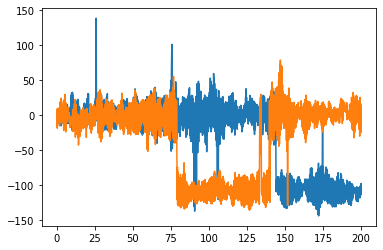

In [5]:
t = np.arange(0,len(x)*dt,dt)
plt.plot(t[:100000],x.T[1][:100000])
plt.plot(t[:100000],x.T[0][:100000])

### Check the Simulation by the Computation of the Potential of Mean Force

#### 1D Landscape

<ipython-input-6-1c4ce89d3613>:4: RuntimeWarning: divide by zero encountered in log
  fe_sim_1d = -np.log(hist_1d)*kT


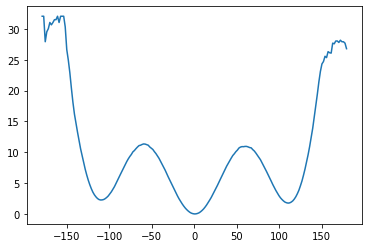

In [6]:
hist,edges=np.histogram(x.T[0], bins=bins1, density=True)
pos_1d =(edges[1:]+edges[:-1])/2
hist_1d = hist
fe_sim_1d = -np.log(hist_1d)*kT
fe_sim_1d[np.where(fe_sim_1d == np.inf)] = np.nanmax(fe_sim_1d[fe_sim_1d != np.inf])
fe_sim_1d -=np.min(fe_sim_1d)

plt.plot(pos_1d,fe_sim_1d)

#### 2D Landscape

simulated


<ipython-input-7-028c5b4046fa>:8: RuntimeWarning: divide by zero encountered in log
  fe_sim_2d = -np.log(hist_2d)*kT


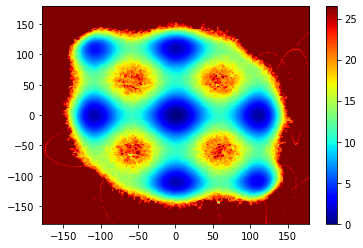

reference


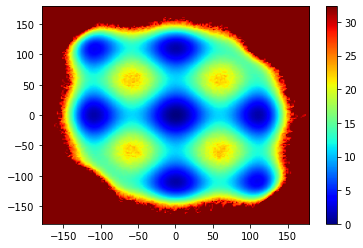

difference


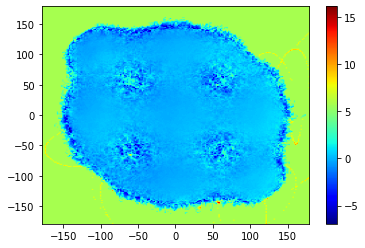

In [7]:
hist=np.histogramdd(np.stack([x.T[0],x.T[1]], axis=1), bins=(bins1,bins2), density=True)

pos_2d_sim = np.zeros((len(bins1)-1,2))
    
for z in range(n_dim):
        pos_2d_sim.T[z] +=(hist[1][z][1:]+hist[1][z][:-1])/2
hist_2d = hist[0] 
fe_sim_2d = -np.log(hist_2d)*kT
fe_sim_2d[np.where(fe_sim_2d == np.inf)] = np.nanmax(fe_sim_2d[fe_sim_2d != np.inf])

fe_sim_2d -=np.min(fe_sim_2d)

print('simulated')
plt.imshow((fe_sim_2d.T), aspect='auto',
           cmap=plt.cm.jet, extent = [np.min(pos_2d.T[0]) , np.max(pos_2d.T[0]), np.min(pos_2d.T[1]) , np.max(pos_2d.T[1])])
plt.colorbar()
plt.show()

print('reference')
plt.imshow((fe_2d.T), aspect='auto',
           cmap=plt.cm.jet, extent = [np.min(pos_2d.T[0]) , np.max(pos_2d.T[0]), np.min(pos_2d.T[1]) , np.max(pos_2d.T[1])])
plt.colorbar()
plt.show()

print('difference')
plt.imshow((fe_2d-fe_sim_2d).T, aspect='auto',
           cmap=plt.cm.jet, extent = [np.min(pos_2d.T[0]) , np.max(pos_2d.T[0]), np.min(pos_2d.T[1]) , np.max(pos_2d.T[1])])
plt.colorbar()
plt.show()


### Extract the 2D Kernel (Note that they won't fit the analytical ones perfectly since the simulation length may be too short)

In [8]:
xvaf1=xvframe(x.T[0],np.gradient(x.T[0],dt),t,fix_time=True)
xvaf2=xvframe(x.T[1],np.gradient(x.T[1],dt),t,fix_time=True)
#create concatenated dataframe
xvaf = xvaf1.join(xvaf2, how='outer', lsuffix='_1', rsuffix='_2')
xvaf.head()

,t_1,x_1,v_1,t_2,x_2,v_2
#t,,,,,,
0.000,0.000,0.000000,-229.902670,0.000,0.000000,-255.367790
0.002,0.002,-0.459805,-232.666049,0.002,-0.510736,-255.326075
0.004,0.004,-0.930664,-237.989526,0.004,-1.021304,-255.175722
0.006,0.006,-1.411763,-242.631271,0.006,-1.531438,-254.593957
0.008,0.008,-1.901189,-246.285296,0.008,-2.039680,-253.069104


In [9]:
mm = multi_dim_gle(trunc = 10, bins = 200, kT =2.494, free_energy = 'MV',physical = True,diagonal_mass = False,plot=False)

t_corr, v_corr_matrix,xU_corr_matrix,force_funcs = mm.compute_correlations_G(xvaf)
#you can use the multiprocessing argument to accelerate the extraction
t_kernel, ikernel_matrix, kernel_matrix= mm.compute_kernel_mat_G(v_corr_matrix,xU_corr_matrix,
                                                          first_kind = True, d  = 0,
                                                          multiprocessing=5)

dimension of system: 2
found dt = 0.002
calculate all correlation functions...
calculate multi-variate free energy landscape


/home/hendrykn123/.local/lib/python3.9/site-packages/multi_mems/multi_dim_gle.py:378: RuntimeWarning: divide by zero encountered in log
  fe=-np.log(hist)


used kT
2.494
constant mass matrix:
[[ 2.99409136e-05 -1.44462291e-06]
 [-1.44462291e-06  3.02324882e-05]]
extract memory kernel entries ...


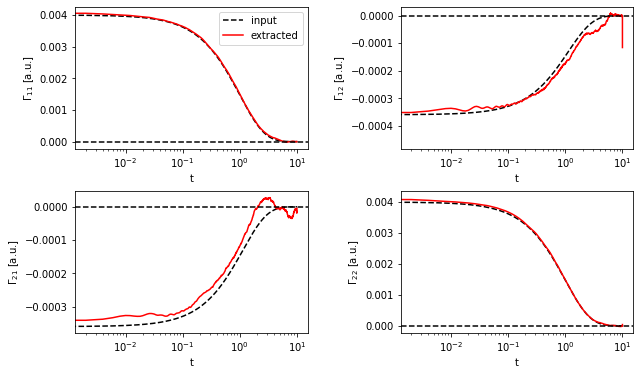

In [10]:
def eigy_expm(A):
    vals,vects = np.linalg.eig(A)
    return np.einsum('...ik, ...k, ...kj -> ...ij',
                     vects,np.exp(vals),np.linalg.inv(vects))

def func_exp(t,gammas,taus):
    
    ks = np.dot(gammas,np.linalg.inv(taus))
    
    A = np.zeros([len(t),2,2])
    for i in range(len(t)):
        A[i] = -t[i]*np.linalg.inv(taus)

    expA = eigy_expm(A)
    func_ana  = np.einsum('jk,ikl -> ijl',ks,expA)
    
    return np.real(func_ana)

kernel_matrix_ana = func_exp(t_kernel,gammas[0],taus[0])

fig, ax = plt.subplots(n_dim,n_dim, figsize=(5*n_dim,3*n_dim))
plt.subplots_adjust(wspace = 0.4)
plt.subplots_adjust(hspace = 0.3)
for i in range(0,n_dim):
    for j in range(0, n_dim): 
        ax[i][j].plot(t_kernel,kernel_matrix_ana.T[j][i], color = 'k',ls='--',label='input')
        ax[i][j].plot(t_kernel,kernel_matrix.T[j][i], color = 'r',label='extracted')
        ax[i][j].set_xscale('log')
        ax[i][j].set_ylabel(r'$\Gamma_{%s%s}$ [a.u.]' % (i+1, j+1))
        ax[i][j].set_xlabel('t')

        ax[i][j].axhline(y = 0, linestyle = '--', color = 'k')
ax[0][0].legend(loc='best')                    
plt.show()